In [138]:
from Dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
import VAE
from Model_Wrapper import Wrapper
import matplotlib.pyplot as plt
import helper
from torchinfo import summary
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
# !bash download.sh afhq-dataset

In [99]:
# Create a dataset and a DataLoader
transforms = {'val':transforms.Compose([
    transforms.Resize([64, 64]),  # Resize the image first
    transforms.ToTensor(),        # Convert PIL image to tensor
    # transforms.Normalize(mean=[0.5], std=[0.5]) 
]),
'train':transforms.Compose([
    transforms.Resize([64, 64]),  # Resize the image first
    # transforms.RandomHorizontalFlip(p=0.5),       # Random horizontal flip
    transforms.ToTensor(),        # Convert PIL image to tensor
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for a single channel
])
}


root_dir = "/home/user/elwakeely1/Cuda_Vision_Lab-/Session5/Solution/data/afhq"

# Initialize dataset
train_dataset = Dataset(root_dir=root_dir, split="train", transform=transforms["train"])
test_dataset = Dataset(root_dir=root_dir, split="val", transform=transforms["val"])


In [100]:
print(f"train size: {train_dataset.__len__()}\ntest size: {test_dataset.__len__()}")

train size: 14630
test size: 1500


In [101]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=8,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,num_workers=8,pin_memory=True)
print("test_dataset per epoch",next(iter(test_loader))[0].size())

test_dataset per epoch torch.Size([64, 1, 64, 64])


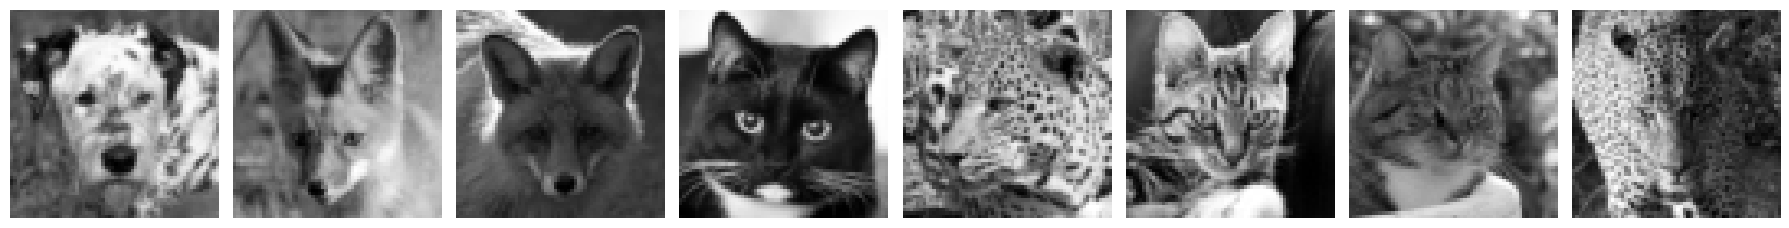

In [102]:
imgs, _ = next(iter(train_loader)) 
fig, ax = plt.subplots(1, 8, figsize=(18, 5))  
for i in range(8):
    ax[i].imshow(imgs[i].squeeze(0), cmap="gray")  
    ax[i].axis("off")
plt.tight_layout()
plt.show()

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Kullback-Leibler Divergence (KLD): 
encourages the latent space to match a standard normal distribution.

Weighting Parameter (lambda_kld):
lambda_kld scales the KLD term to balance its importance relative to the reconstruction loss.
A smaller value (e.g.,10^-3) emphasizes reconstruction more, while a larger value gives more weight to the KLD.
This is the closed-form solution for KLD between two Gaussian distributions.

In [152]:
vae = VAE.VanillaVAE(in_size=(1,64,64), sizes=[4096, 1256, 512, 16], act="ReLU")
vae = vae.to(device)
summary(vae,input_size=((1,64,64)))

Layer (type:depth-idx)                   Output Shape              Param #
VanillaVAE                               [1, 1, 64, 64]            --
├─Sequential: 1-1                        [1, 512]                  643,584
│    └─Flatten: 2-1                      [1, 4096]                 --
│    └─Linear: 2-2                       [1, 1256]                 5,145,832
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-3                         [1, 1256]                 --
├─Sequential: 1-3                        --                        (recursive)
│    └─Linear: 2-4                       [1, 512]                  643,584
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-5                         [1, 512]                  --
├─Linear: 1-5                            [1, 16]                   8,208
├─Linear: 1-6                            [1, 16]                   8,208
├─Sequential: 1-7                  

In [153]:
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-3)
# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)

/home/user/elwakeely1/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [154]:
writer = helper.new_writer("models","VanillaVAE")
train = Wrapper(model_name="VanillaVAE", model = vae, device = device, criterion = vae_loss_function, optimizer = optimizer,writer=writer,show_progress_bar= True)
train.train(10,train_loader,test_loader)
writer.close()

  0%|          | 0/229 [00:00<?, ?it/s]

Epoch 1 Iter 229: loss 0.04091.: 100%|██████████| 229/229 [00:05<00:00, 43.01it/s]

Train Loss 0.05215


Test Loss 0.04443
    Test recons_Loss 0.04016
    Test kld_Loss 4.26847


Epoch 2 Iter 229: loss 0.04548.: 100%|██████████| 229/229 [00:05<00:00, 44.07it/s]

Train Loss 0.04272


Test Loss 0.04088
    Test recons_Loss 0.0368
    Test kld_Loss 4.0785


Epoch 3 Iter 229: loss 0.04319.: 100%|██████████| 229/229 [00:05<00:00, 42.99it/s]

Train Loss 0.04114


Test Loss 0.04079
    Test recons_Loss 0.03673
    Test kld_Loss 4.05958


Epoch 4 Iter 229: loss 0.04147.: 100%|██████████| 229/229 [00:05<00:00, 43.82it/s]

Train Loss 0.04071


Test Loss 0.04033
    Test recons_Loss 0.03649
    Test kld_Loss 3.83148


Epoch 5 Iter 229: loss 0.03184.: 100%|██████████| 229/229 [00:05<00:00, 44.09it/s]

Train Loss 0.03918


Test Loss 0.03774
    Test recons_Loss 0.03316
    Test kld_Loss 4.57109


Epoch 6 Iter 229: loss 0.03492.: 100%|██████████| 229/229 [00:05<00:00, 43.53it/s]

Train Loss 0.03788


Test Loss 0.03711
    Test recons_Loss 0.03292
    Test kld_Loss 4.19105


Epoch 7 Iter 229: loss 0.03357.: 100%|██████████| 229/229 [00:05<00:00, 43.12it/s]

Train Loss 0.03659


Test Loss 0.03553
    Test recons_Loss 0.03017
    Test kld_Loss 5.36267


Epoch 8 Iter 229: loss 0.03710.: 100%|██████████| 229/229 [00:05<00:00, 44.31it/s]

Train Loss 0.03577


Test Loss 0.03524
    Test recons_Loss 0.03028
    Test kld_Loss 4.95893


Epoch 9 Iter 229: loss 0.03403.: 100%|██████████| 229/229 [00:05<00:00, 44.13it/s]

Train Loss 0.03535


Test Loss 0.03505
    Test recons_Loss 0.03025
    Test kld_Loss 4.80074


Epoch 10 Iter 229: loss 0.03336.: 100%|██████████| 229/229 [00:05<00:00, 43.93it/s]

Train Loss 0.03527


Test Loss 0.03492
    Test recons_Loss 0.0298
    Test kld_Loss 5.11932


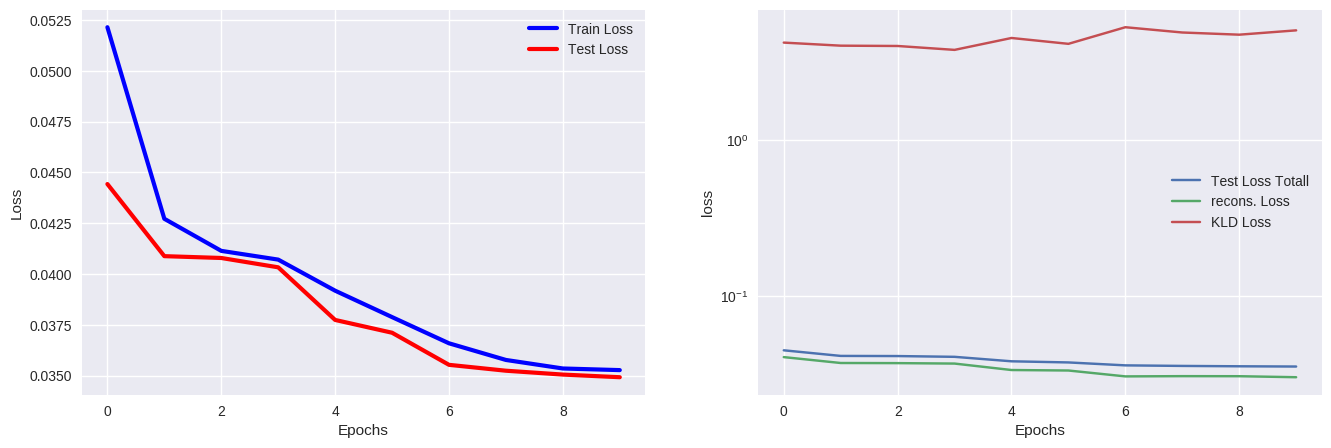

In [155]:
train.plot_loss_acc()

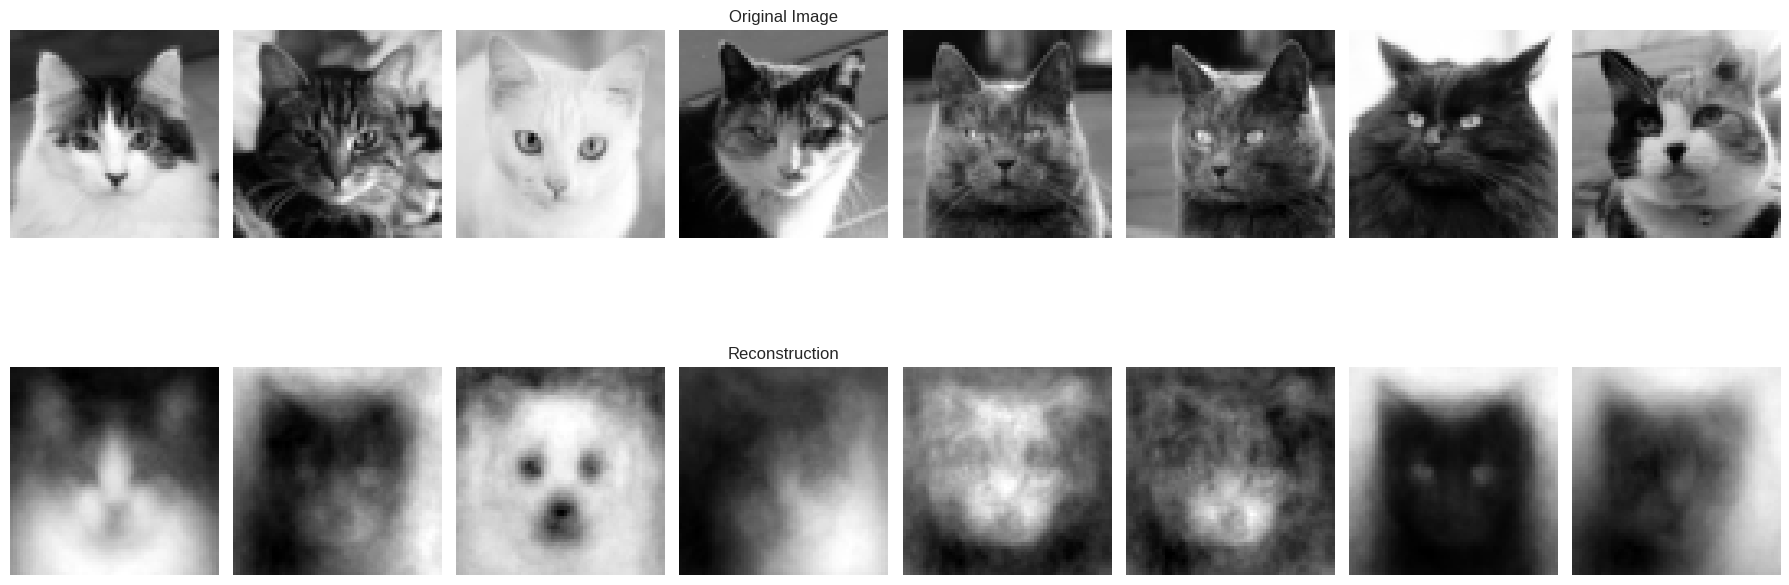

In [156]:
imgs, _ = next(iter(test_loader)) 

vae.eval()
with torch.no_grad():
    recons, _ = vae(imgs.to(device))
    
fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 8)
for i in range(8):
    ax[0, i].imshow(imgs[i, 0], cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].imshow(recons[i, 0].cpu(), cmap="gray")
    ax[1, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()

In [162]:
# our latent space (bottleneck) is 64-dim
LATENT_DIM = 16
NUM_SAMPLES = 10

latents = torch.randn((NUM_SAMPLES, LATENT_DIM), device=device)
with torch.no_grad():
    gen_imgs = vae.decoder(latents)
    gen_imgs = gen_imgs.reshape(NUM_SAMPLES, 1, 64, 64)

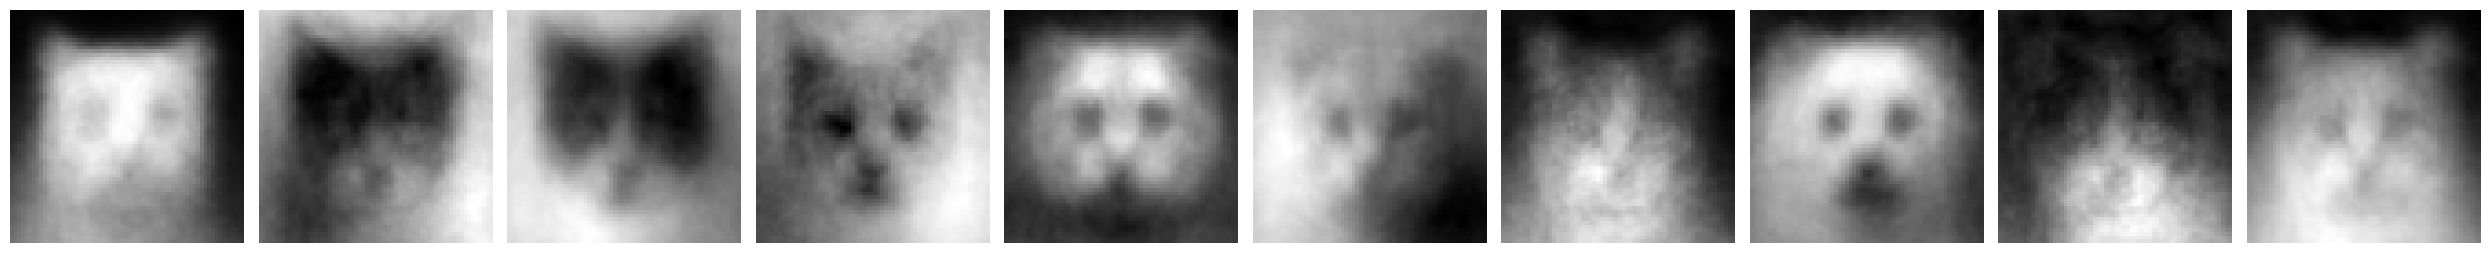

In [158]:
fig, ax = plt.subplots(1, 10)
fig.set_size_inches(25, 3)
for i in range(10):
    ax[i].imshow(gen_imgs[i, 0].cpu(), cmap="gray")
    ax[i].axis("off")
fig.tight_layout()
plt.show()

In [159]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = vae(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

In [160]:
COLORS = ['r','b','g']
def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")

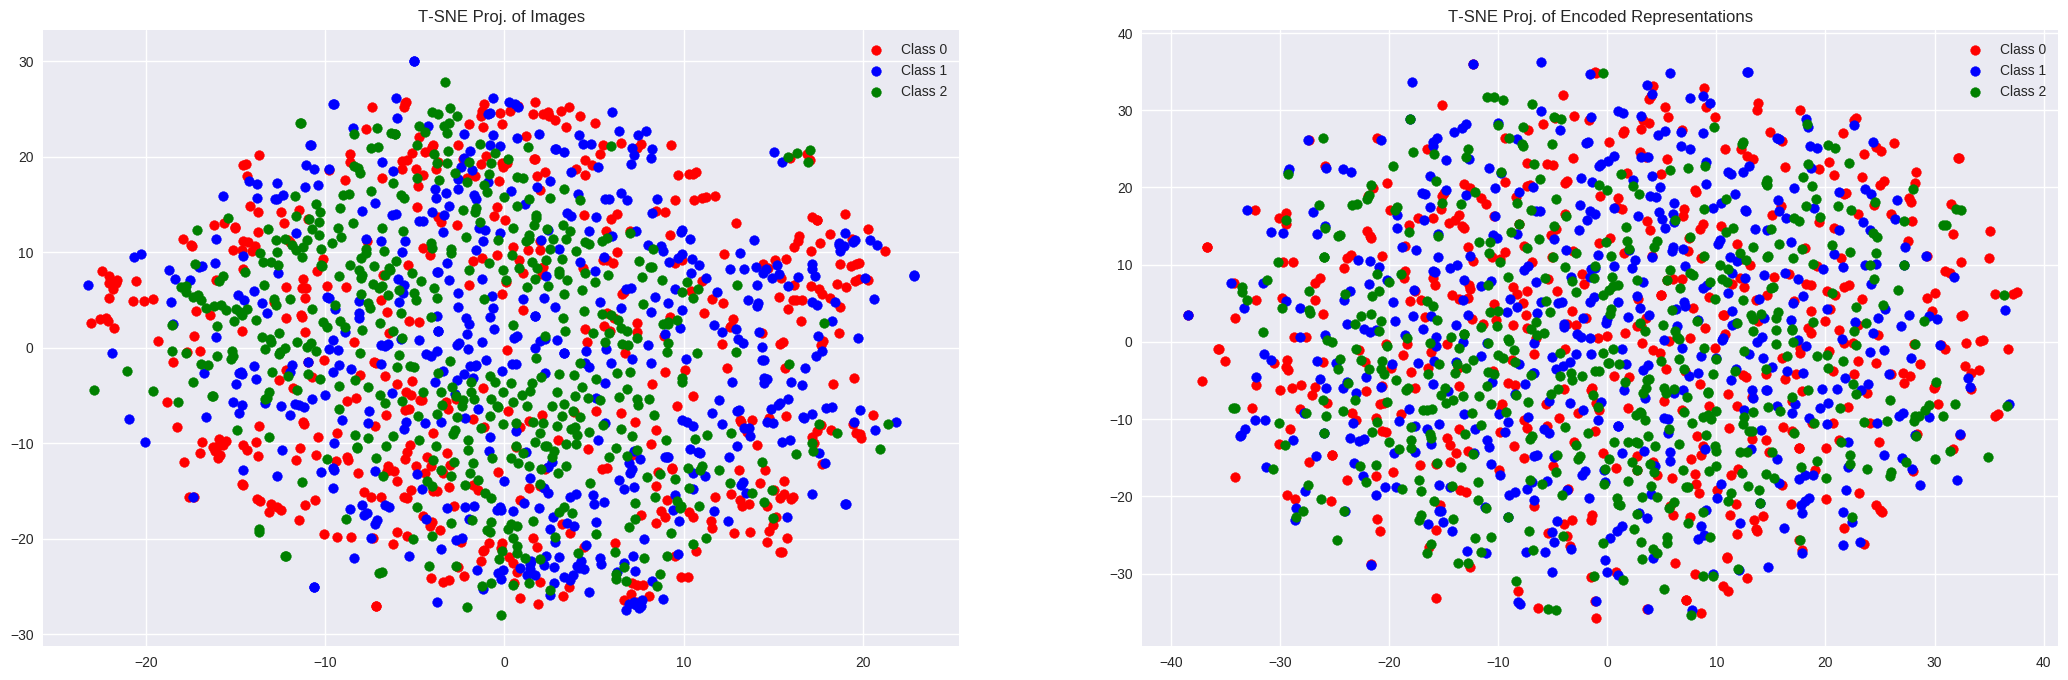

In [161]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_latents = TSNE(n_components=2).fit_transform(latents[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0])
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:N], labels[:N], ax=ax[1])
ax[1].set_title("T-SNE Proj. of Encoded Representations")
plt.show()

# Convolution Variational autoencoder 

In [192]:
conv_vae = VAE.ConvVAE()
conv_vae = conv_vae.to(device)
summary(conv_vae,input_size=(1,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
ConvVAE                                  [1, 1, 64, 64]            --
├─Sequential: 1-1                        [256, 4, 4]               --
│    └─Conv2d: 2-1                       [32, 32, 32]              544
│    └─ReLU: 2-2                         [32, 32, 32]              --
│    └─Conv2d: 2-3                       [64, 16, 16]              32,832
│    └─ReLU: 2-4                         [64, 16, 16]              --
│    └─Conv2d: 2-5                       [128, 8, 8]               131,200
│    └─ReLU: 2-6                         [128, 8, 8]               --
│    └─Conv2d: 2-7                       [256, 4, 4]               524,544
├─Linear: 1-2                            [1, 10]                   40,970
├─Linear: 1-3                            [1, 10]                   40,970
├─Linear: 1-4                            [1, 4096]                 45,056
├─Sequential: 1-5                        [1, 1, 64, 64]   

In [193]:
optimizer = torch.optim.Adam(conv_vae.parameters(), lr=3e-3)
# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1, verbose=True)

/home/user/elwakeely1/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [194]:
writer = helper.new_writer("models","ConvVAE")
train = Wrapper(model_name="COnvVAE", model = conv_vae, device = device, criterion = vae_loss_function, optimizer = optimizer,writer=writer,show_progress_bar= True)
train.train(5,train_loader,test_loader)
writer.close()

  0%|          | 0/229 [00:00<?, ?it/s]

Epoch 1 Iter 229: loss 0.03254.: 100%|██████████| 229/229 [00:05<00:00, 44.69it/s]

Train Loss 0.04794


Test Loss 0.03501
    Test recons_Loss 0.02956
    Test kld_Loss 5.45236


Epoch 2 Iter 229: loss 0.03168.: 100%|██████████| 229/229 [00:05<00:00, 45.53it/s]

Train Loss 0.03428


Test Loss 0.03371
    Test recons_Loss 0.02685
    Test kld_Loss 6.86917


Epoch 3 Iter 229: loss 0.03059.: 100%|██████████| 229/229 [00:05<00:00, 44.77it/s]

Train Loss 0.03349


Test Loss 0.03322
    Test recons_Loss 0.02601
    Test kld_Loss 7.20427


Epoch 4 Iter 229: loss 0.03227.: 100%|██████████| 229/229 [00:05<00:00, 45.16it/s]

Train Loss 0.03319


Test Loss 0.0335
    Test recons_Loss 0.02685
    Test kld_Loss 6.65139


Epoch 5 Iter 229: loss 0.03407.: 100%|██████████| 229/229 [00:05<00:00, 45.54it/s]

Train Loss 0.03313


Test Loss 0.03298
    Test recons_Loss 0.02582
    Test kld_Loss 7.16065


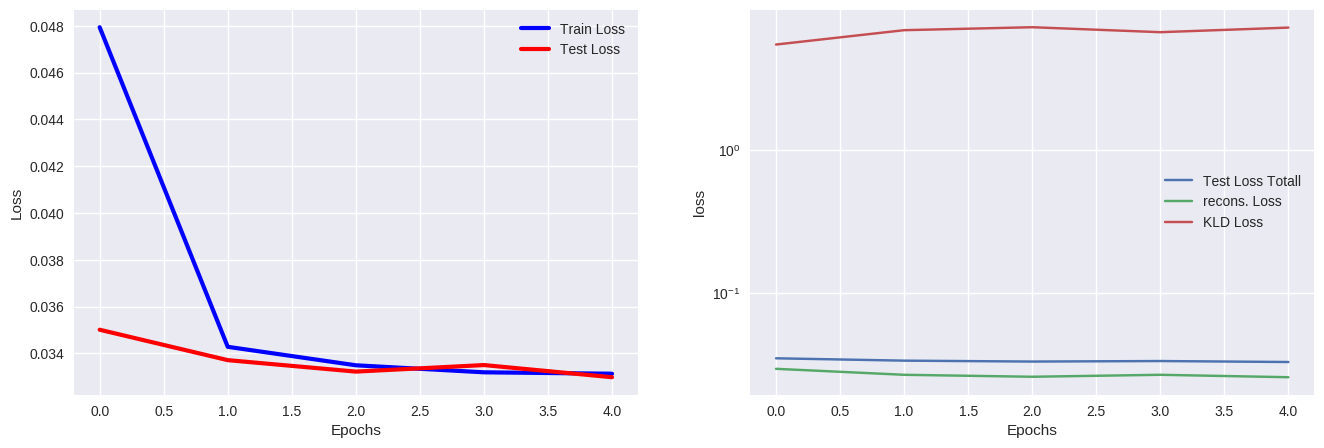

In [195]:
train.plot_loss_acc()

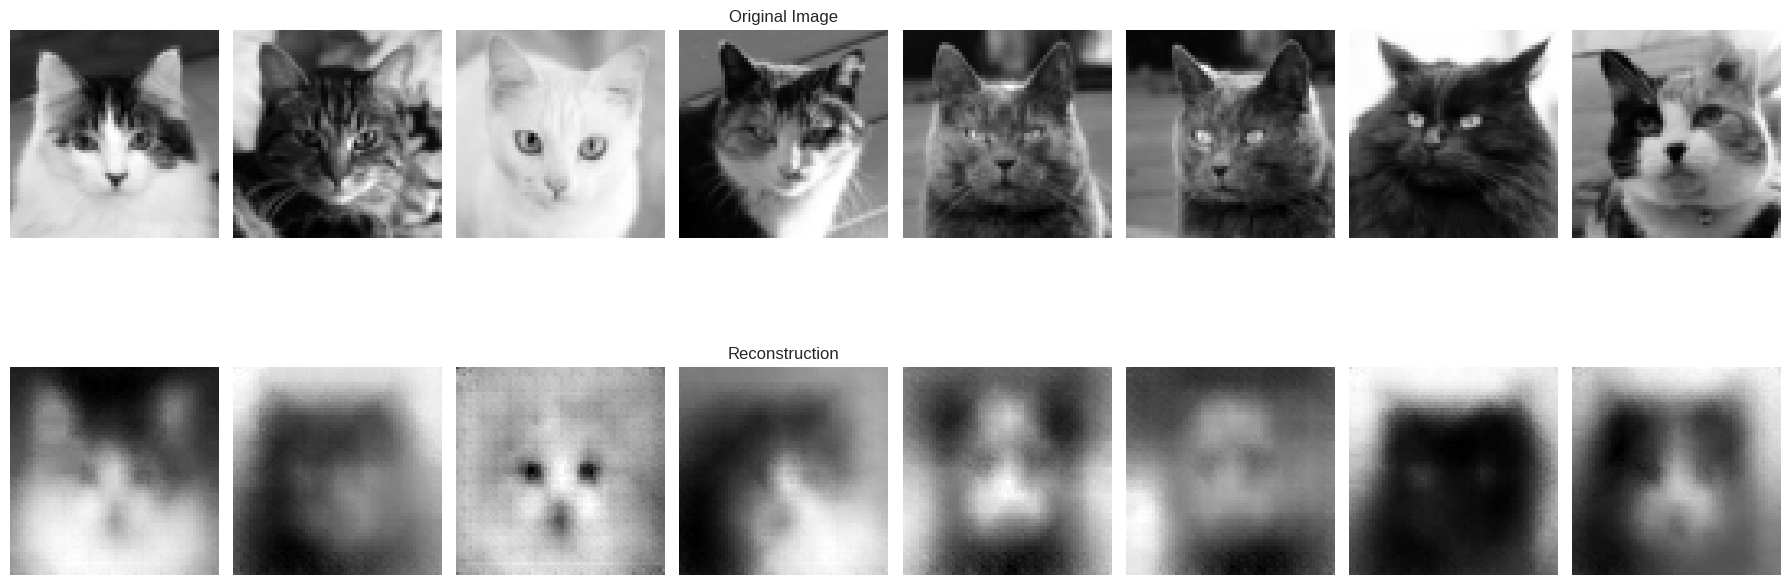

In [196]:
imgs, _ = next(iter(test_loader)) 

conv_vae.eval()
with torch.no_grad():
    recons, _ = conv_vae(imgs.to(device))
    
fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 8)
for i in range(8):
    ax[0, i].imshow(imgs[i, 0], cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].imshow(recons[i, 0].cpu(), cmap="gray")
    ax[1, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()

In [199]:
# our latent space (bottleneck) is 64-dim
LATENT_DIM = 10
NUM_SAMPLES = 10

latents = torch.randn((NUM_SAMPLES, LATENT_DIM), device=device)
with torch.no_grad():
    gen_imgs =conv_vae.decode(latents)
    gen_imgs = gen_imgs.reshape(NUM_SAMPLES, 1, 64, 64)

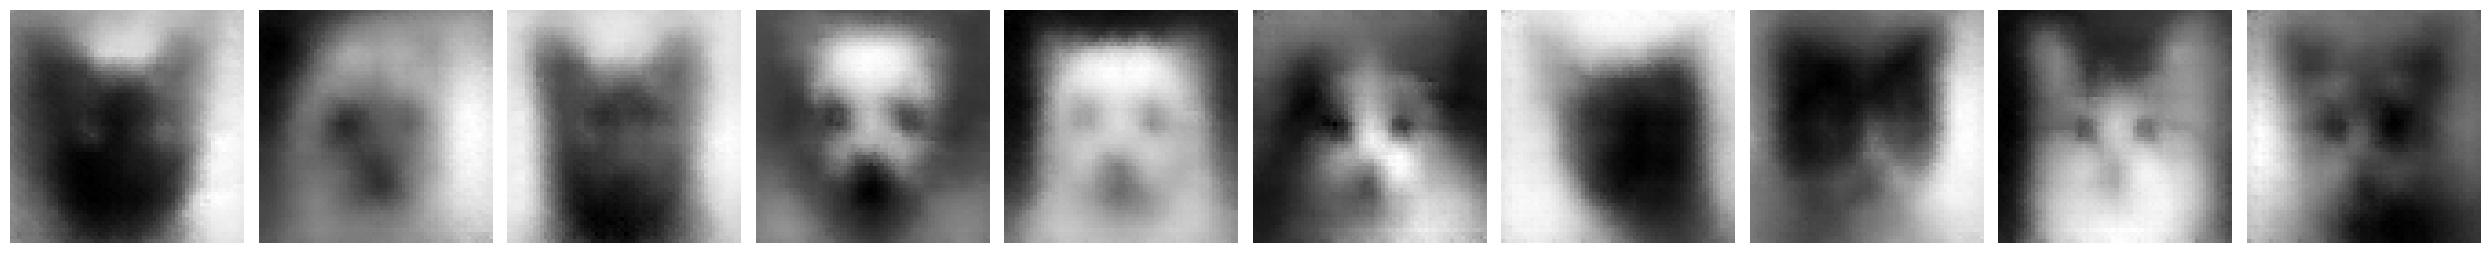

In [200]:
fig, ax = plt.subplots(1, 10)
fig.set_size_inches(25, 3)
for i in range(10):
    ax[i].imshow(gen_imgs[i, 0].cpu(), cmap="gray")
    ax[i].axis("off")
fig.tight_layout()
plt.show()

In [201]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = conv_vae(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

In [202]:
COLORS = ['r','b','g']
def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")

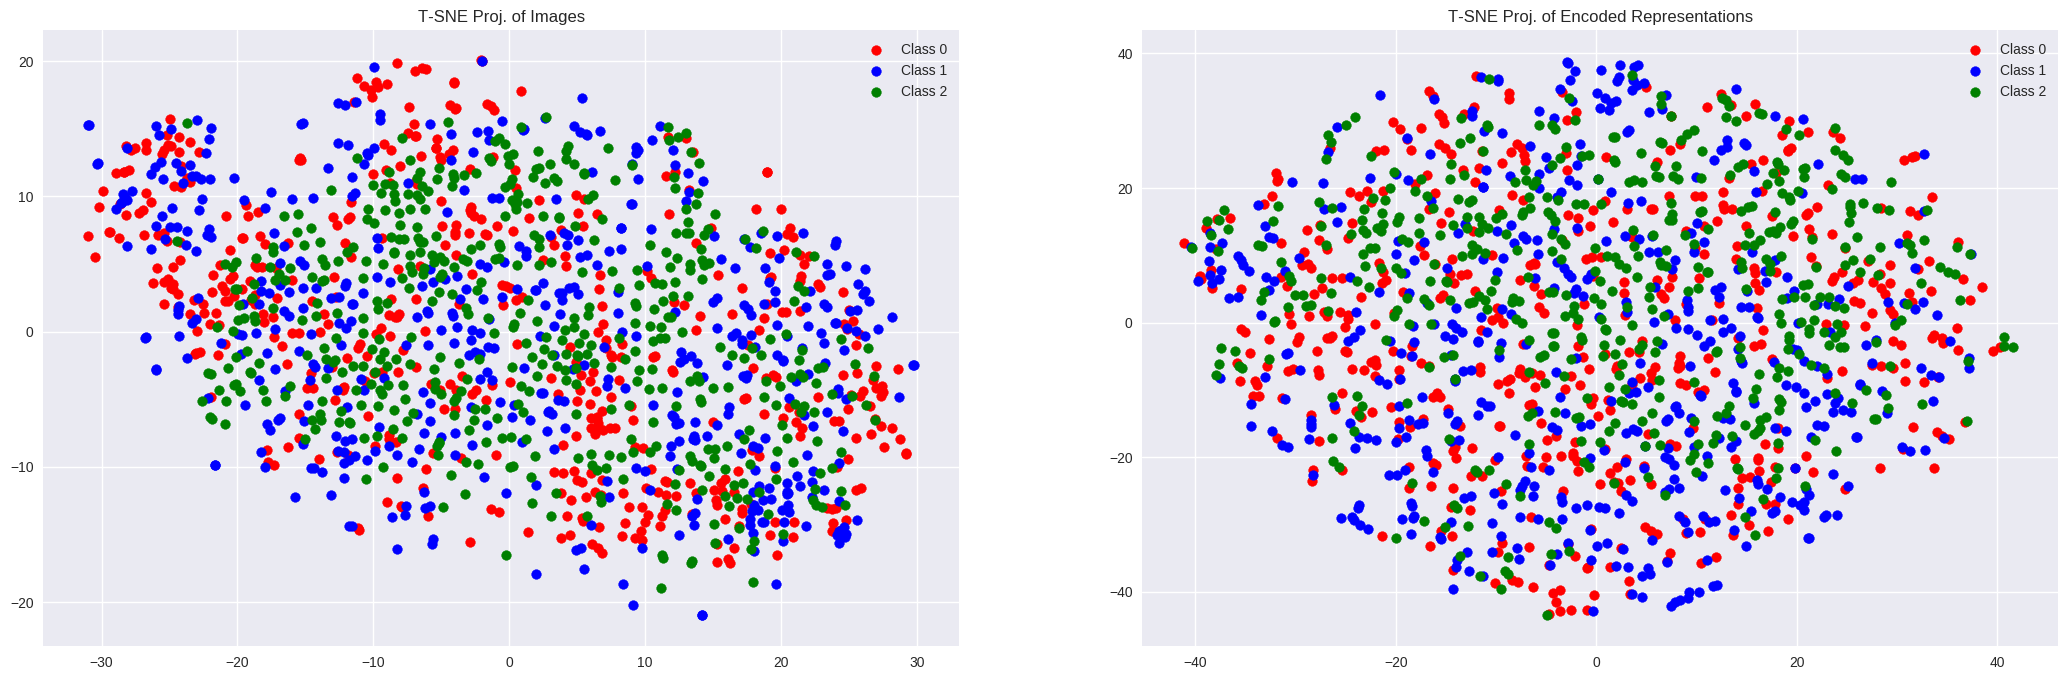

In [203]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_latents = TSNE(n_components=2).fit_transform(latents[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0])
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:N], labels[:N], ax=ax[1])
ax[1].set_title("T-SNE Proj. of Encoded Representations")
plt.show()